# INSY 670: Social Media Analytics - Group Project

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
import nltk
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from rich import print
import warnings
from utils import (
    assign_topic,
    get_topic_submissions,
    create_bipartite_graph,
    create_topic_network,
    get_top_users,
    get_communities,
    calculate_centralities,
    get_filtered_topic_graph,
    get_largest_component,
    get_community_dataframe,
    plot_community_graph,
    project_bipartite_graph,
    show_community_before_after,
    analyze_community,
    get_posts_by_community,
    show_top_influencers,
    show_word_comparison,
    get_sentiment,
    get_top_influencers,
    show_sentiment_comparison,
)

# %load_ext cudf.pandas
%load_ext rich
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

nltk.download("stopwords")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
pyLDAvis.enable_notebook()
tqdm.pandas()

os.makedirs("./data", exist_ok=True)
os.makedirs("./graphs", exist_ok=True)

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
SUBREDDIT_NAME = "FortNiteBR"
TIME_THRESHOLD = pd.Timestamp('2023-06-01 00:00:00')

### Submissions

In [3]:
SUBMISSIONS_DIR = "./data/reddit/processed/submissions/"
SUBMISSIONS_FILES = os.listdir(SUBMISSIONS_DIR)

SUBMISSIONS_IDS = sorted([int(x.split("_")[1]) for x in SUBMISSIONS_FILES])

submissions = []

for file_id in SUBMISSIONS_IDS[::-1]:
    x = pd.read_csv(f"{SUBMISSIONS_DIR}{SUBREDDIT_NAME}_{file_id}_submissions.csv")
    earliest_date = pd.to_datetime(x["created_utc"], unit="s").min()

    submissions.append(x)

    if earliest_date <= TIME_THRESHOLD:
        print(f"Threshold reached at {file_id}")
        break

submissions = pd.concat(submissions)

Threshold reached at 62

In [4]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0
36367,[deleted],1.685873e+09,NaN,14084k4,True,0,0,[deleted],FortNiteBR,t5_3oeyf,2527697,I need your help gamers of Asian servers.,NaN,0.0,0.0
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0


### Comments

In [5]:
COMMENTS_DIR = "./data/reddit/processed/comments/"
COMMENTS_FILES = os.listdir(COMMENTS_DIR)

COMMENTS_IDS = sorted([int(x.split("_")[1]) for x in COMMENTS_FILES])

comments = []

for file_id in COMMENTS_IDS[::-1]:
  x = pd.read_csv(f'{COMMENTS_DIR}{SUBREDDIT_NAME}_{file_id}_comments.csv')
  earliest_date = pd.to_datetime(x['created_utc'], unit='s').min()

  comments.append(x)

  if earliest_date <= TIME_THRESHOLD:
    print(f"Threshold reached at {file_id}")
    break

comments = pd.concat(comments)

Threshold reached at 264

In [6]:
submissions = submissions[~submissions["author"].isin(["[deleted]", "[removed]"])]
comments = comments[~comments["author"].isin(["[deleted]", "[removed]"])]
comments["submission_id"] = comments["link_id"].str.split("t3_").str[1]

In [7]:
comments

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink,submission_id
0,C1:S5 Ace. I don’t really main anyone anymore ...,t1_kf1801a,t3_18r8jxr,t3_18r8jxr,0,FortNiteBR,1,1,TheRedDragonCW,1.703624e+09,/r/FortNiteBR/comments/18r8jxr/what_was_your_f...,18r8jxr
1,"I joked with my friend about how ""Jesus is PRO...",t1_kf1802a,t3_18qygsb,t1_kf17vmd,0,FortNiteBR,1,1,itsMagicMaddie,1.703624e+09,/r/FortNiteBR/comments/18qygsb/what_does_your_...,18qygsb
2,I normally play shuffle with a bunch of preset...,t1_kf181gz,t3_18r8l3g,t3_18r8l3g,0,FortNiteBR,1,1,darkdeath174,1.703624e+09,/r/FortNiteBR/comments/18r8l3g/drop_your_main_...,18r8l3g
3,Quite literally yes,t1_kf181my,t3_18io9yb,t1_kdgrbx9,0,FortNiteBR,1,1,Much_Election6247,1.703624e+09,/r/FortNiteBR/comments/18io9yb/this_is_how_i_f...,18io9yb
4,Merry marauder cos I’m matching with my gf. Bu...,t1_kf182gr,t3_18r8l3g,t3_18r8l3g,0,FortNiteBR,1,1,yhavmin,1.703624e+09,/r/FortNiteBR/comments/18r8l3g/drop_your_main_...,18r8l3g
...,...,...,...,...,...,...,...,...,...,...,...,...
67492,Comparison here and there,t1_jnj5ic1,t3_14564y3,t3_14564y3,0,FortNiteBR,1,1,ogg_ogg,1.686320e+09,/r/FortNiteBR/comments/14564y3/literally_the_s...,14564y3
67493,Bro your dumber than a kindergartener\n💀,t1_jnj5ieb,t3_14551we,t1_jnj0n0e,0,FortNiteBR,-34,-34,Ambitious-Growth-627,1.686320e+09,/r/FortNiteBR/comments/14551we/by_the_way_the_...,14551we
67494,I’m hyped up for the new battle pass,t1_jnj5iry,t3_144pkh0,t3_144pkh0,0,FortNiteBR,1,1,SuperSonicRacing534,1.686320e+09,/r/FortNiteBR/comments/144pkh0/fortnite_chapte...,144pkh0
67495,The gorilla tag group they're in really seals ...,t1_jnj5j0m,t3_14565g7,t1_jnj5f63,0,FortNiteBR,9,9,Cheap-Pie8077,1.686320e+09,/r/FortNiteBR/comments/14565g7/my_son_got_bann...,14565g7


## Topic modeling

In [8]:
submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year

In [9]:
# Clean submission title
stop_words = stopwords.words("english")
stop_words.extend(["fortnite", "fortnitebr"])


def clean_post_title(post):
    return " ".join(
        [
            word
            for word in simple_preprocess(post)
            if word not in stop_words and len(word) > 2
        ]
    )

In [10]:
sample = submissions["title"].sample(10, random_state=42).tolist()
print(sample)

sample_cleaned = [clean_post_title(post) for post in sample]
print(sample_cleaned)

[
    'Team Wipe...RIP Trios',
    'I might just be the next Ninja',
    'Will the OG Paradigm skin make a return?',
    'Chat, what if this was real?',
    'Hawaii servers',
    'is the starwars skins gonna stay until tomorrow? i’m gifting it but i have to wait another day to gift it to 
them.',
    "POV: You're going to open vault and see the teammate with no kills already waiting there",
    'Everyone confirms his presence Get ready for #giveawayUSER on Sunday #giveaways #giveawayindonesia 
#giveawayindo #giveawaycontest #Giveawaytime #giveawayolshop #giveaway2023 #giveawayph #giveawayhijab 
#giveawaywithzoi #fortnitememe #fortnitenews #fortnitewin',
    'Junk Junction Got Junked. Fortnite Chapter 1 Elimination Game DAY 2: Vote Out Your Least Favorite Location 
(Link To Vote In Body Text Of Post)',
    'cheaters teaming up against me in solos. \U0001fae4'
]

[
    'team wipe rip trios',
    'might next ninja',
    'paradigm skin make return',
    'chat real',
    'hawaii servers',
    'starwars skins gonna stay tomorrow gifting wait another day gift',
    'pov going open vault see teammate kills already waiting',
    'everyone confirms presence get ready giveawayuser sunday giveaways giveawayindo giveawaycontest giveawaytime 
giveawayolshop giveaway giveawayph giveawayhijab giveawaywithzoi fortnitememe fortnitenews fortnitewin',
    'junk junction got junked chapter elimination game day vote least favorite location link vote body text post',
    'cheaters teaming solos'
]

In [11]:
submissions["clean_title"] = submissions["title"].progress_apply(clean_post_title)

100%|██████████| 150744/150744 [00:04<00:00, 35014.43it/s]


In [12]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,got level gave extra rewards
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0,2023,fornite lego skins
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0,2023,best jonesy ever
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,items locker missing
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,anyone else get vbucks rocket league stuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,Blue-Gryphon297,1.685871e+09,self.FortNiteBR,1407q4f,True,4,0,I've won maybe two games in the dozens I've pl...,FortNiteBR,t5_3oeyf,2527696,What is with the MMR system lately?,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,mmr system lately
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0,2023,guys check crazy video pls like subscribe
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,career leaderboard
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,still possible get


In [13]:
titles = submissions['clean_title'].apply(str.split)
id2word = corpora.Dictionary(titles)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<6075 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary<8861 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary<11104 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary<12884 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary<14531 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary<15875 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #70000 to Dictionary<17706 unique tokens: 

In [14]:
corpus = [id2word.doc2bow(title) for title in titles]

In [15]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=3,
    passes=5,
    iterations=200,
    random_state=42
)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 5 topics, 5 passes over the supplied corpus of 150744 documents, updating every 6000 documents, evaluating every ~60000 documents, iterating 200x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 3 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/150744, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/150744, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/150744, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/150744, outstanding queue size

In [16]:
print(lda_model.print_topics())

INFO:gensim.models.ldamodel:topic #0 (0.200): 0.035*"epic" + 0.022*"skin" + 0.020*"account" + 0.018*"shop" + 0.017*"skins" + 0.015*"concept" + 0.012*"games" + 0.012*"item" + 0.011*"new" + 0.010*"add"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.027*"help" + 0.019*"ranked" + 0.018*"need" + 0.014*"build" + 0.014*"play" + 0.013*"please" + 0.013*"win" + 0.011*"someone" + 0.011*"question" + 0.011*"zero"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.046*"season" + 0.023*"chapter" + 0.022*"battle" + 0.016*"new" + 0.015*"map" + 0.015*"pass" + 0.012*"one" + 0.010*"next" + 0.010*"get" + 0.009*"creative"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.036*"game" + 0.025*"like" + 0.021*"back" + 0.012*"would" + 0.011*"time" + 0.009*"think" + 0.008*"new" + 0.008*"see" + 0.007*"idea" + 0.007*"really"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.040*"anyone" + 0.026*"skin" + 0.023*"bug" + 0.022*"else" + 0.021*"know" + 0.012*"get" + 0.009*"best" + 0.008*"happened" + 0.007*"ever" + 0.007*"style"

[
    (
        0,
        '0.035*"epic" + 0.022*"skin" + 0.020*"account" + 0.018*"shop" + 0.017*"skins" + 0.015*"concept" + 
0.012*"games" + 0.012*"item" + 0.011*"new" + 0.010*"add"'
    ),
    (
        1,
        '0.027*"help" + 0.019*"ranked" + 0.018*"need" + 0.014*"build" + 0.014*"play" + 0.013*"please" + 0.013*"win"
+ 0.011*"someone" + 0.011*"question" + 0.011*"zero"'
    ),
    (
        2,
        '0.046*"season" + 0.023*"chapter" + 0.022*"battle" + 0.016*"new" + 0.015*"map" + 0.015*"pass" + 0.012*"one"
+ 0.010*"next" + 0.010*"get" + 0.009*"creative"'
    ),
    (
        3,
        '0.036*"game" + 0.025*"like" + 0.021*"back" + 0.012*"would" + 0.011*"time" + 0.009*"think" + 0.008*"new" + 
0.008*"see" + 0.007*"idea" + 0.007*"really"'
    ),
    (
        4,
        '0.040*"anyone" + 0.026*"skin" + 0.023*"bug" + 0.022*"else" + 0.021*"know" + 0.012*"get" + 0.009*"best" + 
0.008*"happened" + 0.007*"ever" + 0.007*"style"'
    )
]

In [17]:
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

print(topic_words)

[
    (
        0,
        [
            ('epic', 0.03502236),
            ('skin', 0.022128774),
            ('account', 0.019705739),
            ('shop', 0.017938394),
            ('skins', 0.017189682),
            ('concept', 0.014997258),
            ('games', 0.0119368695),
            ('item', 0.011535828),
            ('new', 0.011011584),
            ('add', 0.009795354)
        ]
    ),
    (
        1,
        [
            ('help', 0.027400833),
            ('ranked', 0.01916317),
            ('need', 0.01815914),
            ('build', 0.014073851),
            ('play', 0.013676924),
            ('please', 0.0130168395),
            ('win', 0.012675491),
            ('someone', 0.011311942),
            ('question', 0.010823206),
            ('zero', 0.010816099)
        ]
    ),
    (
        2,
        [
            ('season', 0.0462472),
            ('chapter', 0.02269368),
            ('battle', 0.021948406),
            ('new', 0.015705762),
            ('map', 0.015167701),
            ('pass', 0.015008558),
            ('one', 0.0124044465),
            ('next', 0.010495917),
            ('get', 0.010000212),
            ('creative', 0.009291727)
        ]
    ),
    (
        3,
        [
            ('game', 0.036082484),
            ('like', 0.02474486),
            ('back', 0.021438478),
            ('would', 0.011670931),
            ('time', 0.010525526),
            ('think', 0.008955904),
            ('new', 0.008239535),
            ('see', 0.0082075875),
            ('idea', 0.0071555628),
            ('really', 0.0070563704)
        ]
    ),
    (
        4,
        [
            ('anyone', 0.04049292),
            ('skin', 0.025927208),
            ('bug', 0.022915766),
            ('else', 0.022060696),
            ('know', 0.021256048),
            ('get', 0.011969835),
            ('best', 0.008743512),
            ('happened', 0.0077808695),
            ('ever', 0.007125999),
            ('style', 0.0069842595)
        ]
    )
]

### Topic Summaries

- Topic 0: Skins and Cosmetic Items
    - Keywords: "skin", "skins", "back", "concept", "shop"
    - Summary: This topic focuses on discussions around different skins, back blings, and other cosmetic items available in the Fortnite item shop. Conversations revolve around cosmetic customization options.


- Topic 1: Gameplay and Game Modes
    - Keywords: "ranked", "build", "play", "mode", "crew"
    - Summary: Encompasses discussions about the core gameplay aspects of Fortnite, including building mechanics, ranked mode, and other game modes. Suggests conversations around different ways to experience the game.

- Topic 2: Fortnite Seasons and Map Changes  
    - Keywords: "season", "chapter", "map", "new"
    - Summary: This topic covers discussions related to the different seasons, chapters, and map updates in Fortnite. Indicates conversations about the evolving content and changes to the game world over time.

- Topic 3: Player Support and Account Issues
    - Keywords: "help", "account", "need", "epic"  
    - Summary: Relates to players seeking help or support, potentially with issues related to their Fortnite accounts or in-game problems. Indicates discussions around troubleshooting and assistance from the developer Epic Games.

- Topic 4: Bugs, Glitches, and In-Game Issues
    - Keywords: "bug", "glitch", "quest", "creative", "emote"
    - Summary: Revolves around discussions of bugs, glitches, and other issues encountered within the game. Suggests conversations about reporting and addressing various in-game problems or unintended behaviors.

In [18]:
topic_names = {
    0: "Skins, Cosmetics, and In-Game Shop",
    1: "General Questions and Discussions",
    2: "New Seasons, Updates, and Map Changes",
    3: "Player Support, Account Issues, and Quests",
    4: "Bugs, Glitches, and Gameplay Experiences",
}

In [19]:
submissions["topic"] = assign_topic(lda_model, corpus, topic_names)

submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title,topic
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,got level gave extra rewards,"Bugs, Glitches, and Gameplay Experiences"
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0,2023,fornite lego skins,"Skins, Cosmetics, and In-Game Shop"
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0,2023,best jonesy ever,"Bugs, Glitches, and Gameplay Experiences"
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,items locker missing,"Skins, Cosmetics, and In-Game Shop"
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,anyone else get vbucks rocket league stuff,"Bugs, Glitches, and Gameplay Experiences"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,Blue-Gryphon297,1.685871e+09,self.FortNiteBR,1407q4f,True,4,0,I've won maybe two games in the dozens I've pl...,FortNiteBR,t5_3oeyf,2527696,What is with the MMR system lately?,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,mmr system lately,"Player Support, Account Issues, and Quests"
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0,2023,guys check crazy video pls like subscribe,General Questions and Discussions
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,career leaderboard,"Player Support, Account Issues, and Quests"
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,still possible get,"Bugs, Glitches, and Gameplay Experiences"


In [20]:
submissions["topic"].value_counts(normalize=True, ascending=False)


topic
Player Support, Account Issues, and Quests    0.248096
Skins, Cosmetics, and In-Game Shop            0.204771
New Seasons, Updates, and Map Changes         0.194999
General Questions and Discussions             0.178594
Bugs, Glitches, and Gameplay Experiences      0.173539
Name: proportion, dtype: float64

## Network analysis

In [21]:
SELECTED_TOPIC = topic_names[0]
print(f'Selected topic: {SELECTED_TOPIC}')

Selected topic: Skins, Cosmetics, and In-Game Shop

In [22]:
submissions_t, comments_t = get_topic_submissions(SELECTED_TOPIC, submissions, comments)

In [23]:
# Convert 'created_utc' to datetime and filter submissions before and after a specific date in one step

submissions_t["post_time"] = pd.to_datetime(submissions_t["created_utc"], unit="s")
cutoff_date = pd.Timestamp("2023-10-01 00:00:00")
submissions_t_before_3m = submissions_t[submissions_t["post_time"] < cutoff_date]
submissions_t_after_3m = submissions_t[submissions_t["post_time"] > cutoff_date]

# Filter comments based on the filtered submissions
comments_t_before_3m = comments_t[
    comments_t["submission_id"].isin(submissions_t_before_3m["id"])
]
comments_t_after_3m = comments_t[
    comments_t["submission_id"].isin(submissions_t_after_3m["id"])
]

comments_t_before_3m.shape, comments_t_after_3m.shape


((114211, 12), (136708, 12))

In [24]:
G_filtered, filtered_node_data, B_t = get_filtered_topic_graph(
    SELECTED_TOPIC,
    submissions_t_after_3m,
    comments_t_after_3m,
)

INFO:UTILS:Adding nodes...
INFO:UTILS:Selected topic: Skins, Cosmetics, and In-Game Shop
INFO:UTILS:The graph has 35078 nodes and 100656 edges.
INFO:UTILS:After filtering for nodes with more than one comment, the graph has 15796 nodes and 36735 edges.


In [25]:
G_filtered_before3m, filtered_node_data_before3m, B_t_before3m = get_filtered_topic_graph(
    SELECTED_TOPIC,
    submissions_t_before_3m,
    comments_t_before_3m,
    largest_component=False
)

INFO:UTILS:Adding nodes...
INFO:UTILS:Selected topic: Skins, Cosmetics, and In-Game Shop
INFO:UTILS:The graph has 24751 nodes and 83091 edges.
INFO:UTILS:After filtering for nodes with more than one comment, the graph has 11613 nodes and 34125 edges.


In [26]:
G_filtered, communities, community_lens = get_communities(G_filtered, resolution=1)

print(f"Number of communities: {len(communities)}")

print(
    "Community size:", sorted(community_lens.items(), key=lambda x: x[1], reverse=True)
)

Number of communities: 2537

Community size:
[
    (647, 1640),
    (993, 1583),
    (681, 1497),
    (1491, 755),
    (327, 707),
    (621, 614),
    (719, 603),
    (773, 552),
    (534, 525),
    (2202, 492),
    (2008, 429),
    (1003, 417),
    (1212, 412),
    (1929, 397),
    (203, 351),
    (1161, 328),
    (7, 301),
    (624, 293),
    (1304, 275),
    (2291, 224),
    (616, 215),
    (724, 189),
    (2481, 130),
    (27, 129),
    (531, 110),
    (758, 92),
    (222, 10),
    (355, 3),
    (74, 2),
    (90, 2),
    (171, 2),
    (346, 2),
    (804, 2),
    (945, 2),
    (1062, 2),
    (1235, 2),
    (1463, 2),
    (1550, 2),
    (1694, 2),
    (2045, 2),
    (2302, 2),
    (2322, 2),
    (0, 1),
    (1, 1),
    (2, 1),
    (3, 1),
    (4, 1),
    (5, 1),
    (6, 1),
    (8, 1),
    (9, 1),
    (10, 1),
    (11, 1),
    (12, 1),
    (13, 1),
    (14, 1),
    (15, 1),
    (16, 1),
    (17, 1),
    (18, 1),
    (19, 1),
    (20, 1),
    (21, 1),
    (22, 1),
    (23, 1),
    (24, 1),
    (25, 1),
    (26, 1),
    (28, 1),
    (29, 1),
    (30, 1),
    (31, 1),
    (32, 1),
    (33, 1),
    (34, 1),
    (35, 1),
    (36, 1),
    (37, 1),
    (38, 1),
    (39, 1),
    (40, 1),
    (41, 1),
    (42, 1),
    (43, 1),
    (44, 1),
    (45, 1),
    (46, 1),
    (47, 1),
    (48, 1),
    (49, 1),
    (50, 1),
    (51, 1),
    (52, 1),
    (53, 1),
    (54, 1),
    (55, 1),
    (56, 1),
    (57, 1),
    (58, 1),
    (59, 1),
    (60, 1),
    (61, 1),
    (62, 1),
    (63, 1),
    (64, 1),
    (65, 1),
    (66, 1),
    (67, 1),
    (68, 1),
    (69, 1),
    (70, 1),
    (71, 1),
    (72, 1),
    (73, 1),
    (75, 1),
    (76, 1),
    (77, 1),
    (78, 1),
    (79, 1),
    (80, 1),
    (81, 1),
    (82, 1),
    (83, 1),
    (84, 1),
    (85, 1),
    (86, 1),
    (87, 1),
    (88, 1),
    (89, 1),
    (91, 1),
    (92, 1),
    (93, 1),
    (94, 1),
    (95, 1),
    (96, 1),
    (97, 1),
    (98, 1),
    (99, 1),
    (100, 1),
    (101, 1),
    (102, 1),
    (103, 1),
    (104, 1),
    (105, 1),
    (106, 1),
    (107, 1),
    (108, 1),
    (109, 1),
    (110, 1),
    (111, 1),
    (112, 1),
    (113, 1),
    (114, 1),
    (115, 1),
    (116, 1),
    (117, 1),
    (118, 1),
    (119, 1),
    (120, 1),
    (121, 1),
    (122, 1),
    (123, 1),
    (124, 1),
    (125, 1),
    (126, 1),
    (127, 1),
    (128, 1),
    (129, 1),
    (130, 1),
    (131, 1),
    (132, 1),
    (133, 1),
    (134, 1),
    (135, 1),
    (136, 1),
    (137, 1),
    (138, 1),
    (139, 1),
    (140, 1),
    (141, 1),
    (142, 1),
    (143, 1),
    (144, 1),
    (145, 1),
    (146, 1),
    (147, 1),
    (148, 1),
    (149, 1),
    (150, 1),
    (151, 1),
    (152, 1),
    (153, 1),
    (154, 1),
    (155, 1),
    (156, 1),
    (157, 1),
    (158, 1),
    (159, 1),
    (160, 1),
    (161, 1),
    (162, 1),
    (163, 1),
    (164, 1),
    (165, 1),
    (166, 1),
    (167, 1),
    (168, 1),
    (169, 1),
    (170, 1),
    (172, 1),
    (173, 1),
    (174, 1),
    (175, 1),
    (176, 1),
    (177, 1),
    (178, 1),
    (179, 1),
    (180, 1),
    (181, 1),
    (182, 1),
    (183, 1),
    (184, 1),
    (185, 1),
    (186, 1),
    (187, 1),
    (188, 1),
    (189, 1),
    (190, 1),
    (191, 1),
    (192, 1),
    (193, 1),
    (194, 1),
    (195, 1),
    (196, 1),
    (197, 1),
    (198, 1),
    (199, 1),
    (200, 1),
    (201, 1),
    (202, 1),
    (204, 1),
    (205, 1),
    (206, 1),
    (207, 1),
    (208, 1),
    (209, 1),
    (210, 1),
    (211, 1),
    (212, 1),
    (213, 1),
    (214, 1),
    (215, 1),
    (216, 1),
    (217, 1),
    (218, 1),
    (219, 1),
    (220, 1),
    (221, 1),
    (223, 1),
    (224, 1),
    (225, 1),
    (226, 1),
    (227, 1),
    (228, 1),
    (229, 1),
    (230, 1),
    (231, 1),
    (232, 1),
    (233, 1),
    (234, 1),
    (235, 1),
    (236, 1),
    (237, 1),
    (238, 1),
    (239, 1),
    (240, 1),
    (241, 1),
    (242, 1),
    (243, 1),
    (244, 1),
    (245, 1),
    (246, 1),
    (247, 1),
    (248, 1),
    (249, 1),
    (250, 1),
    (251, 1),
 

INFO:main:Analyzing community...


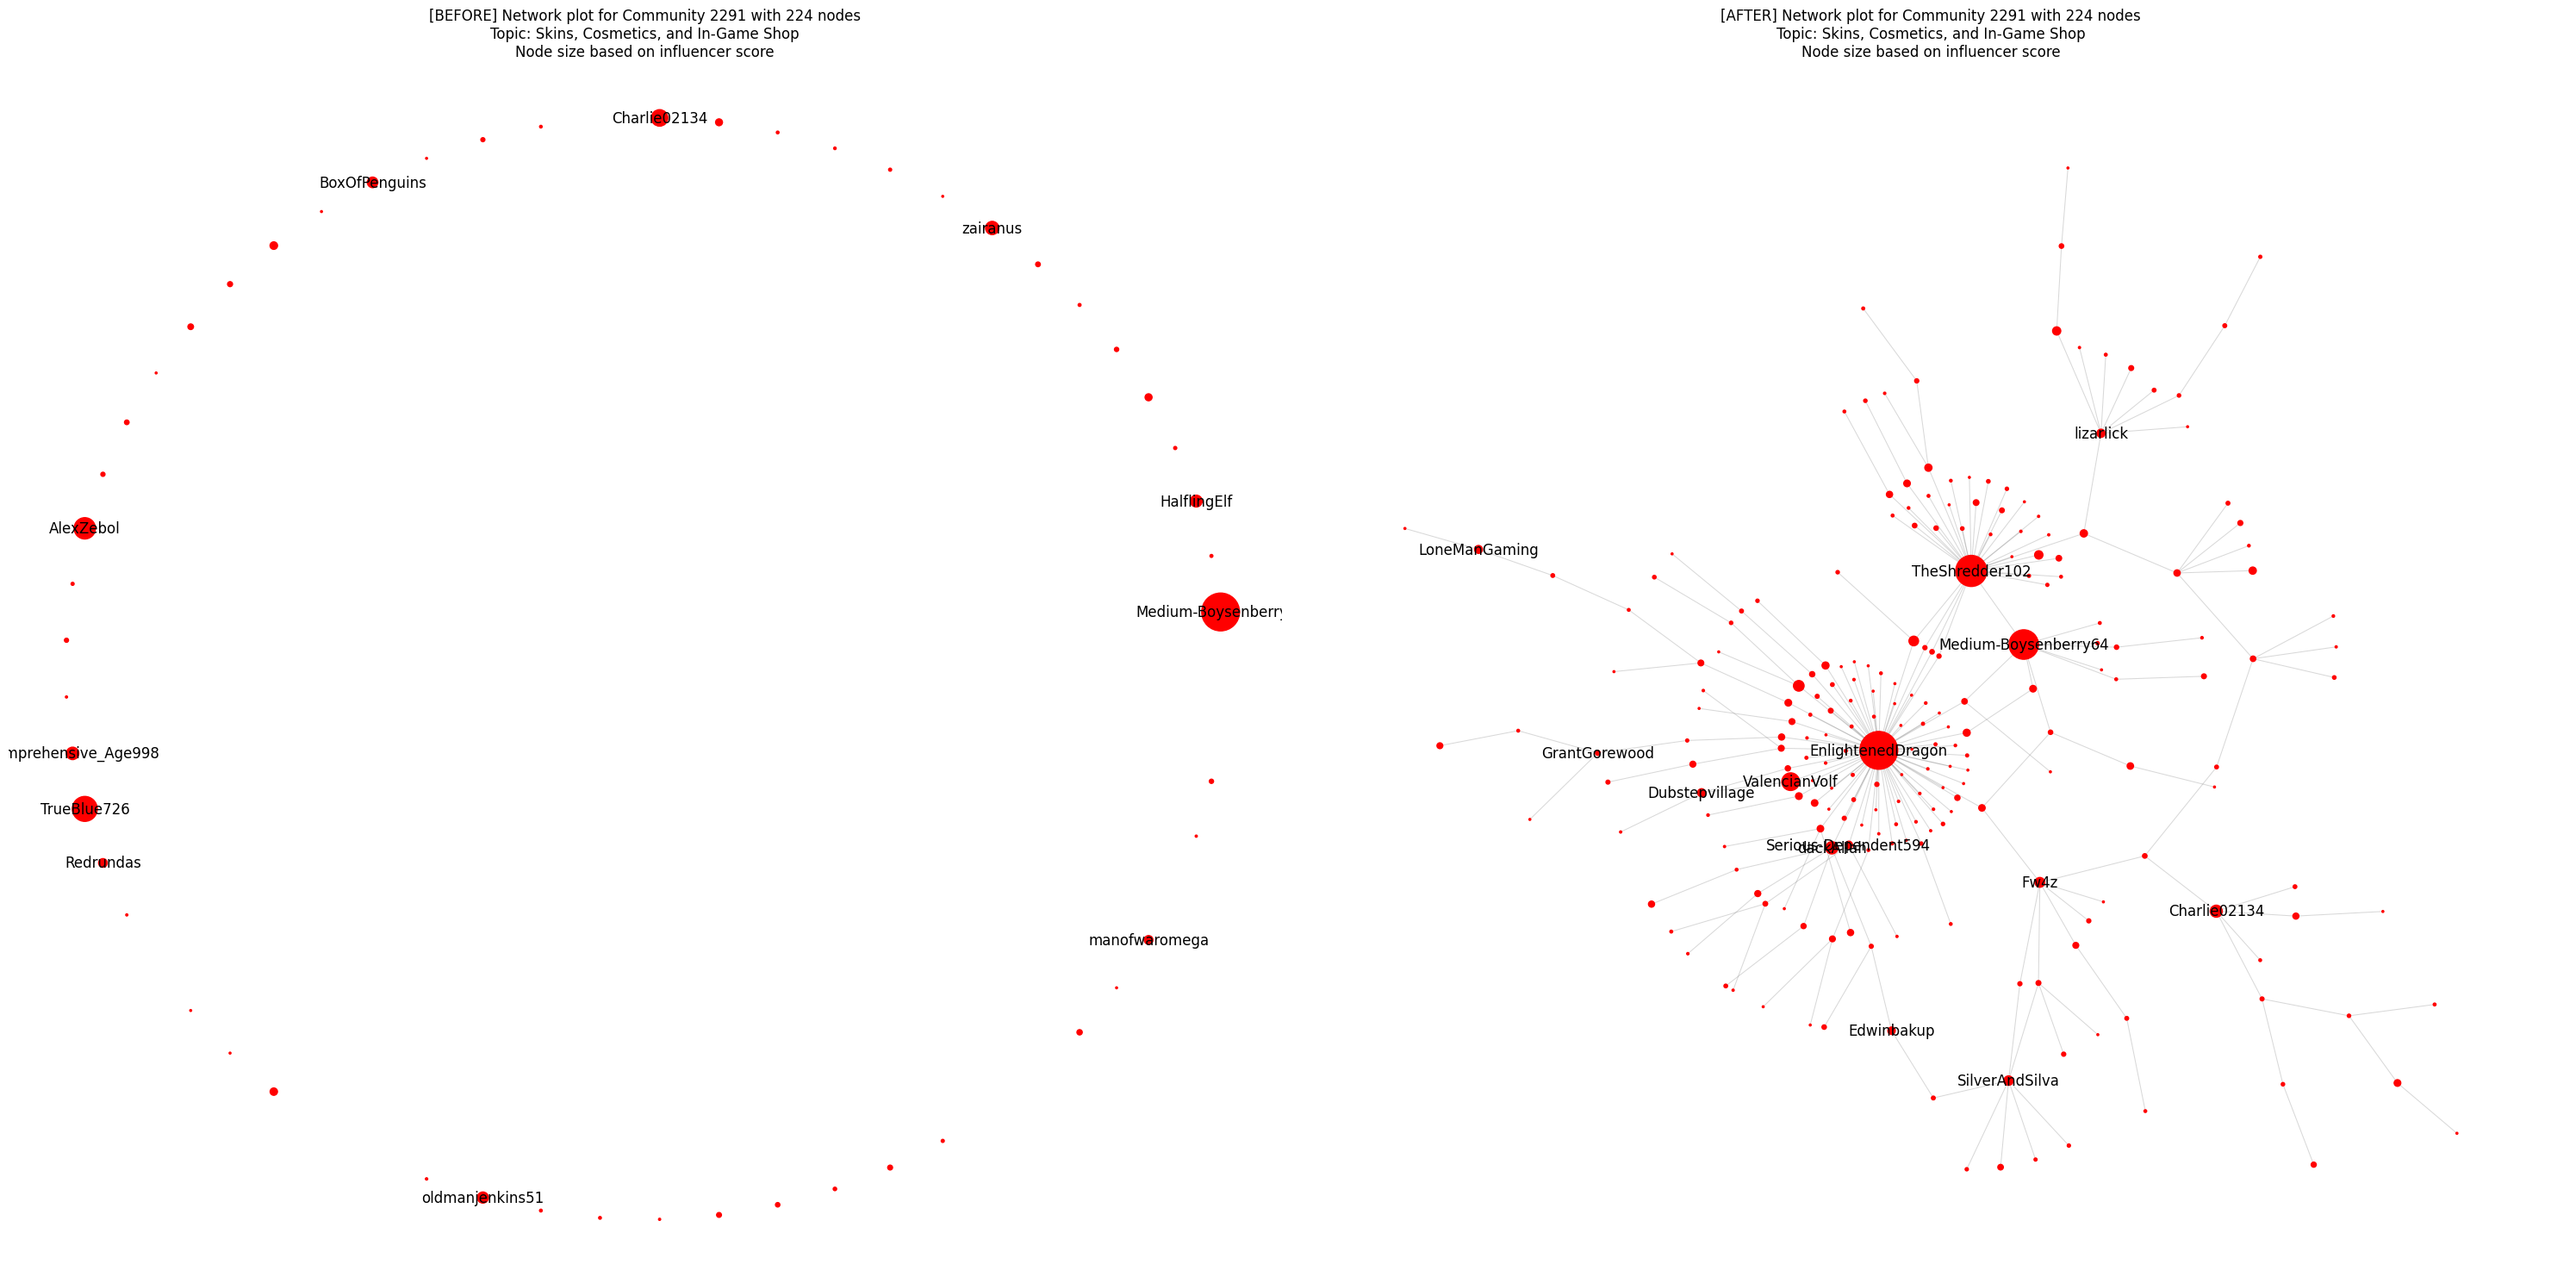

INFO:main:Calculating top influencers...


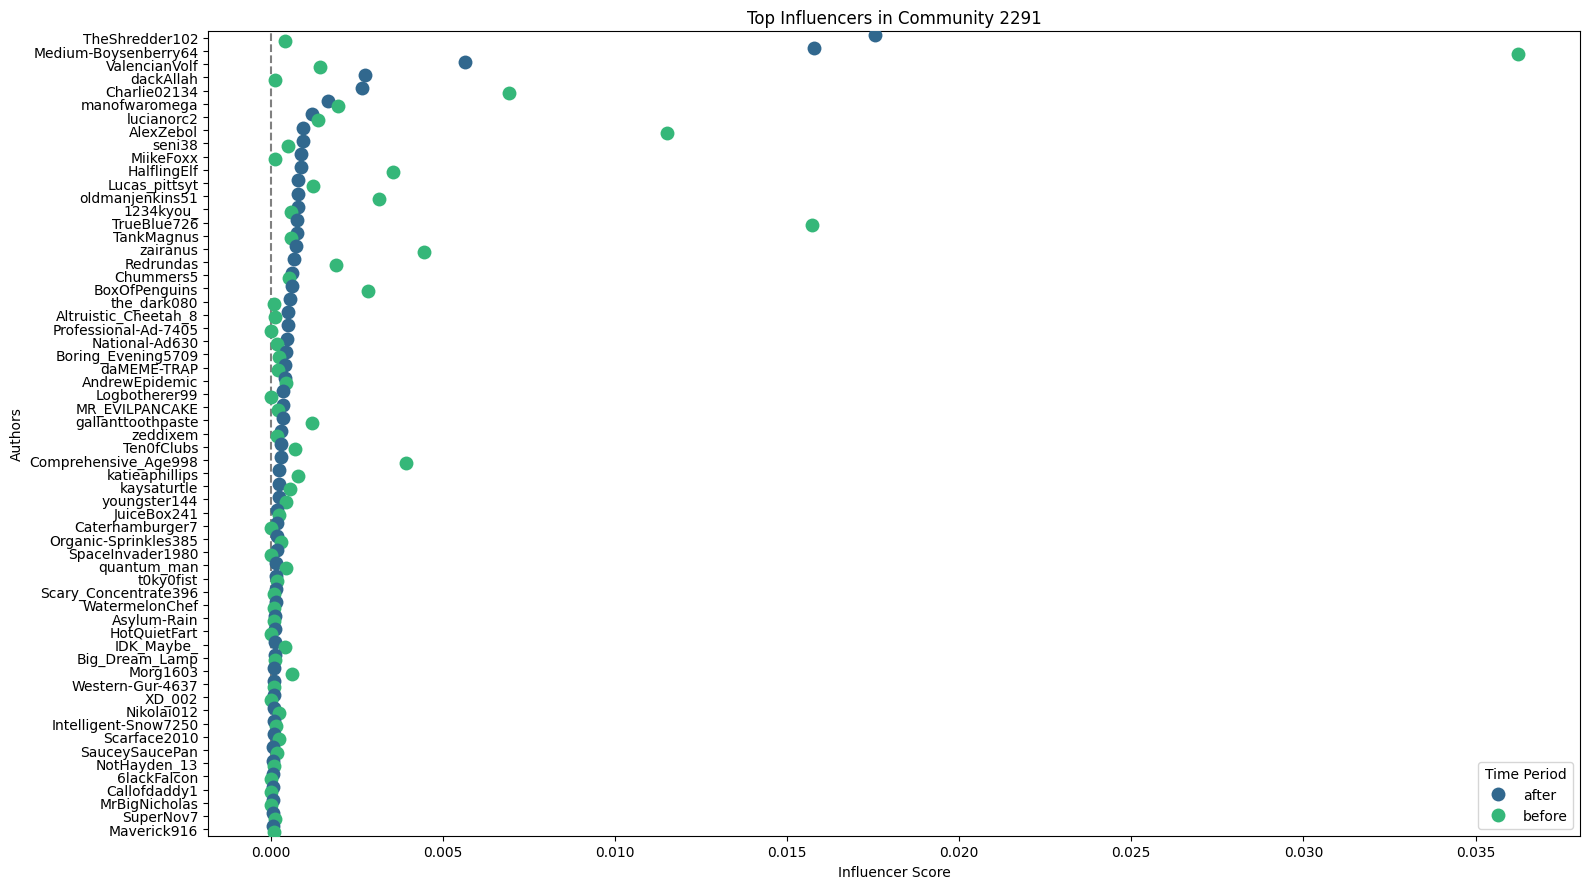

INFO:main:Calculating top words in community post titles...


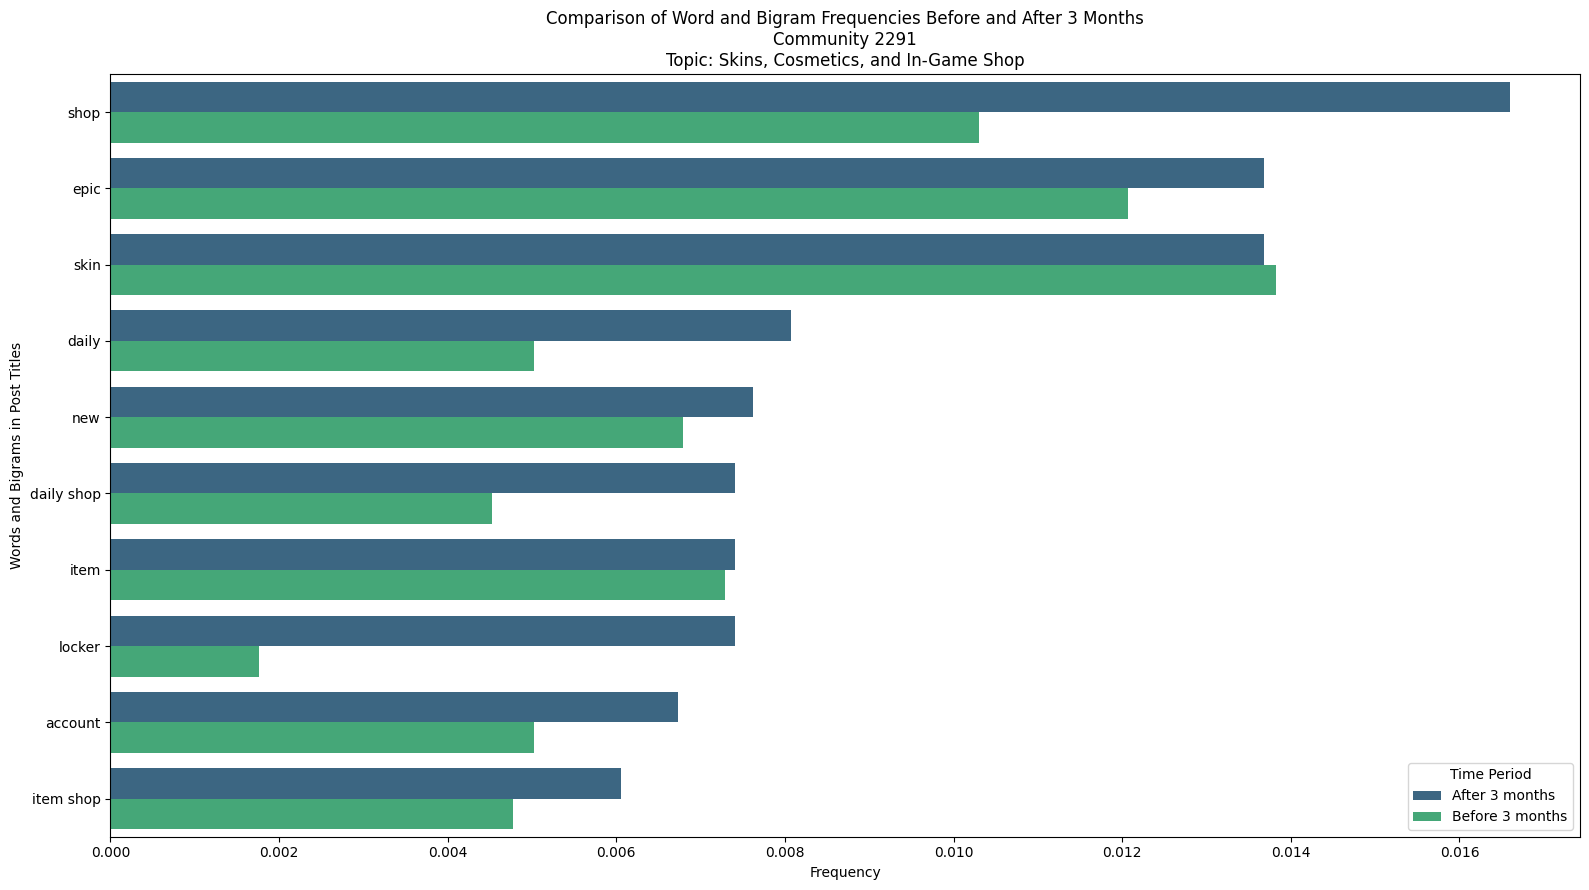

INFO:main:Calculating sentiment scores...
100%|██████████| 1452/1452 [00:42<00:00, 34.17it/s]


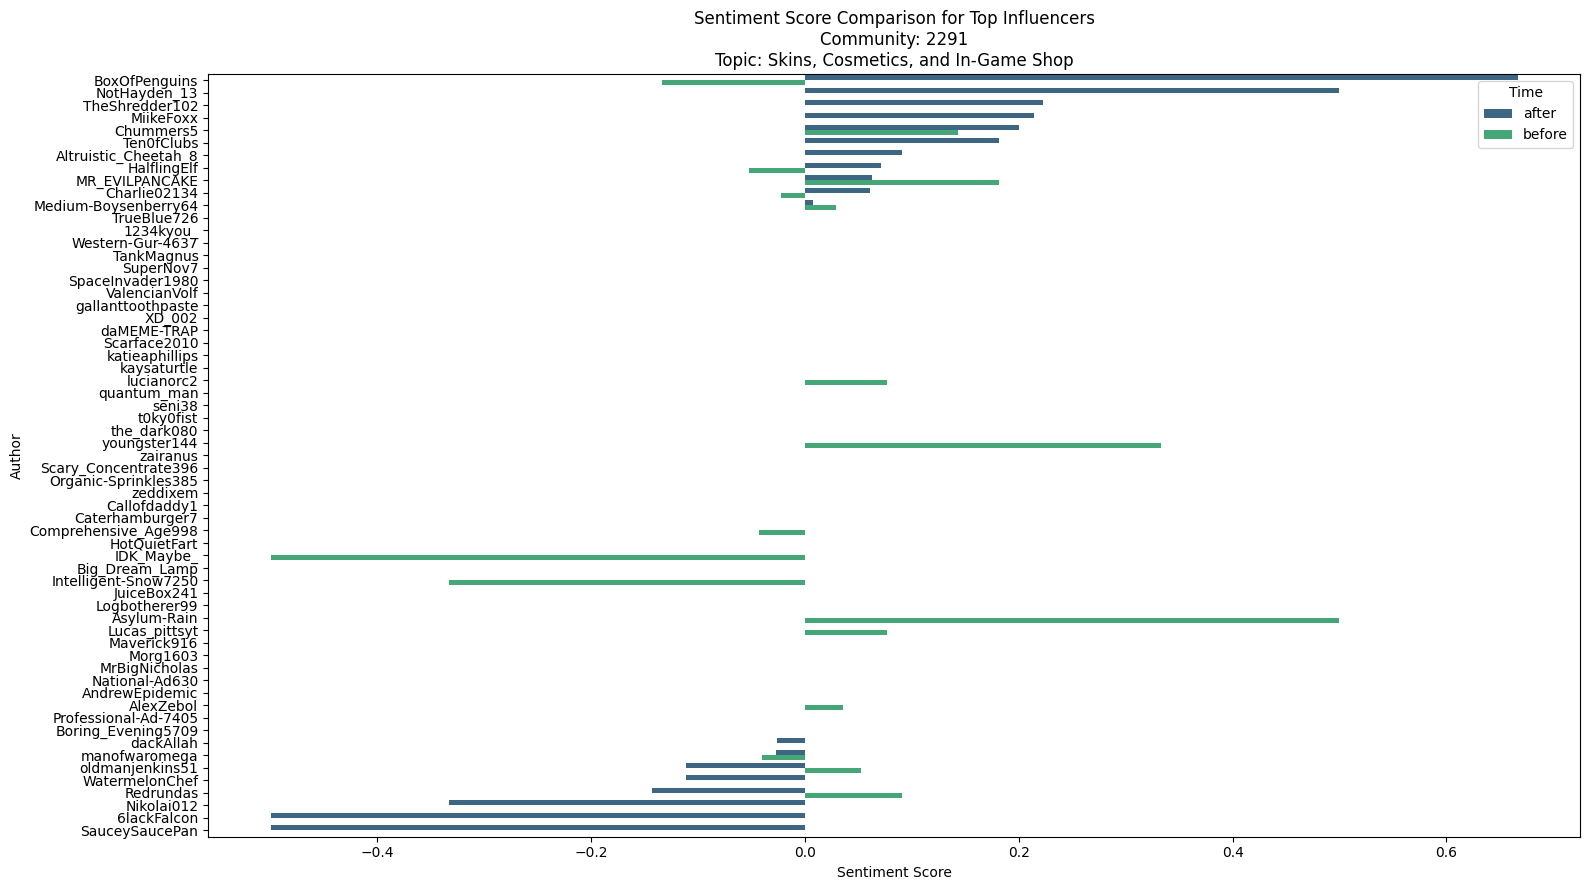

In [32]:
# Change this to select a different community

SELECTED_COMMUNITY_IDX = 2291

logger.info("Analyzing community...")
(
    G_community,
    G_community_before3m,
    author_metrics_overall_t,
    metrics,
) = analyze_community(
    G_filtered,
    G_filtered_before3m,
    communities,
    community_lens,
    SELECTED_COMMUNITY_IDX,
    SELECTED_TOPIC,
    submissions_t_after_3m,
    submissions_t_before_3m,
    comments_t_after_3m,
    comments_t_before_3m,
)

logger.info("Calculating top influencers...")
show_top_influencers(metrics, SELECTED_COMMUNITY_IDX, SELECTED_TOPIC)

logger.info("Calculating top words in community post titles...")

posts_after_3m_community = get_posts_by_community(
    submissions_t_after_3m, comments_t_after_3m, metrics
)
posts_before_3m_community = get_posts_by_community(
    submissions_t_before_3m, comments_t_before_3m, metrics
)

word_comps = show_word_comparison(
    posts_after_3m_community,
    posts_before_3m_community,
    SELECTED_COMMUNITY_IDX,
    SELECTED_TOPIC,
)

logger.info("Calculating sentiment scores...")

influencer_comments, sentiment_score_comparison = get_top_influencers(
    metrics, comments_t_after_3m, comments_t_before_3m
)

show_sentiment_comparison(
    sentiment_score_comparison, SELECTED_COMMUNITY_IDX, SELECTED_TOPIC
)
